In [8]:
import pandas as pd
import numpy as np

data = pd.read_csv('../Data/Auto.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [20]:
data.horsepower.describe()
data.horsepower = pd.to_numeric(data.horsepower, errors='coerce')
data.dropna(subset=['horsepower'], inplace=True)
data.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [21]:
predictor = data['horsepower']
response = data['mpg']

In [28]:
import statsmodels.api as sm

predictor = sm.add_constant(predictor)
model = sm.OLS(response, predictor)
result = model.fit()

In [29]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Tue, 10 Sep 2024   Prob (F-statistic):           7.03e-81
Time:                        15:08:28   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
from ISLP.models import summarize
summarize(result)

,coef,std err,t,P>|t|
const,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


In [31]:
result.params

const         39.935861
horsepower    -0.157845
dtype: float64

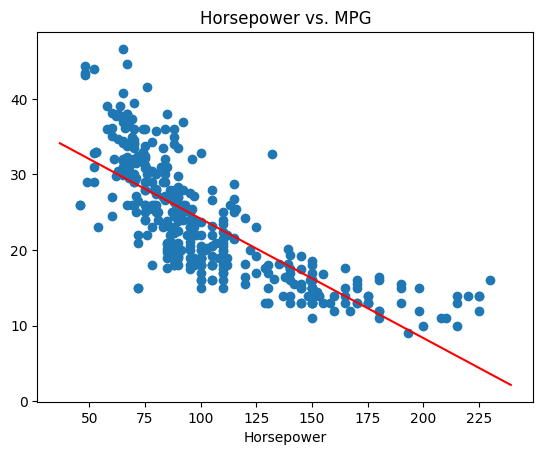

In [33]:
import matplotlib.pyplot as plt

def abline(ax, slope, intercept, *args, **kwargs):
    xlim = ax.get_xlim()
    ylim = [x * slope + intercept for x in xlim]
    ax.plot(xlim, ylim, *args, **kwargs)
    
fig, ax = plt.subplots()
ax.scatter(data.horsepower, data.mpg)
ax.set_title('Horsepower vs. MPG')
ax.set_xlabel('Horsepower')
abline(ax, result.params['horsepower'], result.params['const'], color='red')

#### Hypothesis Test


$H_0$ : There is no relationship between horsepower and mpg, i.e. $\beta_{horsepower} = 0$

In [34]:
from scipy import stats

TSS = np.sum((response - np.mean(response)) ** 2)
RSS = np.sum(result.resid ** 2)
F = ((TSS - RSS) / 1) / (RSS / (len(data) - 2))
p_value = stats.f.sf(F, 1, len(data) - 2)
p_value

np.float64(7.031989029403764e-81)

p_value is almost zero, so we reject the null, meaning there might be a relationship between horsepower and mpg

#### Confidence Interval and Prediction Interval for 98 horsepower


In [36]:
prediction = result.get_prediction([1, 98])
prediction.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,24.467077,0.251262,23.973079,24.961075,14.809396,34.124758


#### Residual plots for problems detection

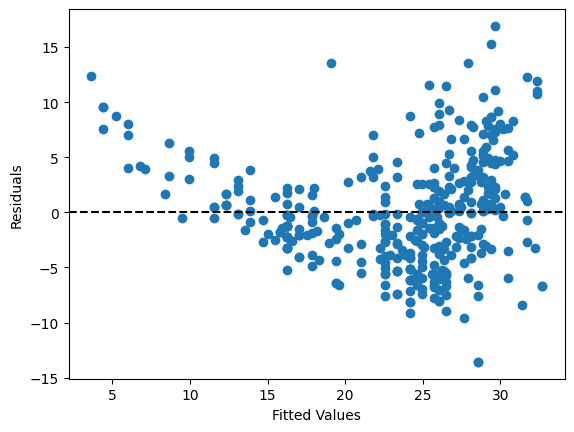

In [41]:
fig, ax = plt.subplots()
ax.scatter(result.fittedvalues, result.resid)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
plt.show()

The residuals are not randomly distributed around 0, which suggests that the variance of residuals is not constant.
There is also a pattern in the residuals, which suggests that the relationship between the predictor and response is not linear.

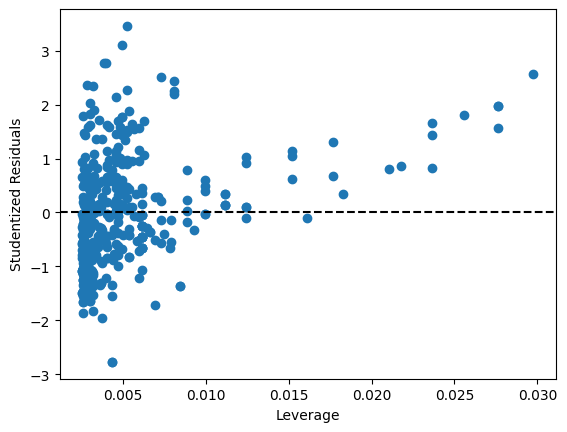

In [42]:
influence = result.get_influence()
leverage = influence.hat_matrix_diag
studenized_residuals = influence.resid_studentized_internal

fig, ax = plt.subplots()
ax.scatter(leverage, studenized_residuals)
ax.axhline(y=0, color='black', linestyle='--')
ax.set_ylabel('Studenized Residuals')
ax.set_xlabel('Leverage')
plt.show()

There are some points with high leverage and high residuals, which are potential outliers.